In [29]:
# -*- coding: utf-8 -*-
#  Copyright 2024 -  United Kingdom Research and Innovation
#  Copyright 2024 -  The University of Manchester
#
#  Licensed under the Apache License, Version 2.0 (the "License");
#  you may not use this file except in compliance with the License.
#  You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
#  Unless required by applicable law or agreed to in writing, software
#  distributed under the License is distributed on an "AS IS" BASIS,
#  WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
#  See the License for the specific language governing permissions and
#  limitations under the License.
#
#   Authored by: Jakob S. Jørgensen (DTU)
#                Gemma Fardell (UKRI-STFC)
#                Edoardo Pasca (UKRI-STFC)     
#                Laura Murgatroyd (UKRI-STFC)
#                Margaret Duff (STFC - UKRI)
#                   

# Helsinki Tomography Challenge - Limited Angle CT Reconstruction 

The purpose of the challenge is to recover the shapes of 2D targets imaged with limited-angle tomography on a lab based cone beam set-up. 

The training set of the HTC2022 challenge consist of homogenous acrylic disc phantoms of 70 mm in diameter, with holes of varying shapes made with a laser cutter. Each disk has a different number of irregular holes in random locations:

![image](./htc_code/htc_discs.jpg)

The outcome of the challenge should be an algorithm which takes in the X-ray data, i.e., the sinogram and it’s associated metadata about the measurement geometry, and produces a reconstruction which has been segmented into two components: air and plastic. For more details of the challenge see https://fips.fi/data-challenges/helsinki-tomography-challenge-2022/ .


The CIL developer team submitted 5 algorithm submissions to the challenge with algorithm 2 gaining 3rd place, the highest non-machine learning based solution. The paper describing the solution can be found https://doi.org/10.3934/ammc.2023011 and a blog https://ccpi.ac.uk/the-helsinki-tomography-challenge-2022-part-1/ 

This notebook takes you through the development and prototyping process used by the team during preparation of the challenge submission. We demonstrate the results on one 60 degree limited angle test data set. 

In this notebook we do not discuss the segmentation, instead use a segmentation algorithm based on Otsu thresholding (for more information see "htc_code/helper_functions.py")

Learning objectives are to see  examples of :
- incorporating prior knowledge of a problem in an variational regularisation framework 
- utilising the flexibility and near-math syntax of the CIL optimisation toolkit to prototype different reconstruction objectives 
- the CIL Block Framework and PDHG optimisation algorithm


## Imports

In [30]:

import numpy as np
from htc_code.helper_functions import *
import matplotlib.pyplot as plt
from skimage.transform import rotate  
from cil.utilities.display import show2D, show_geometry
from cil.recon import FDK
from cil.optimisation.algorithms import FISTA, PDHG
from cil.optimisation.functions import LeastSquares, TotalVariation, L1Norm, MixedL21Norm, L2NormSquared, IndicatorBox, BlockFunction, ZeroFunction
from cil.optimisation.operators import GradientOperator, IdentityOperator, BlockOperator, FiniteDifferenceOperator

## Load the data 

In [31]:

# Load the data:
data = load_htc2022data("./htc_code/test_data/htc2022_ta_sparse_example.mat", dataset_name="CtDataLimited")

In [32]:
#TODO: Try and show the limited angle nature of the data in an intuitive way 

In [33]:
print(data.geometry)

2D Cone-beam tomography
System configuration:
	Source position: [   0.  , -410.66]
	Rotation axis position: [0., 0.]
	Detector position: [  0.  , 143.08]
	Detector direction x: [1., 0.]
Panel configuration:
	Number of pixels: [560   1]
	Pixel size: [0.2 0.2]
	Pixel origin: bottom-left
Channel configuration:
	Number of channels: 1
Acquisition description:
	Number of positions: 121
	Angles 0-9 in degrees: [-0. , -0.5, -1. , -1.5, -2. , -2.5, -3. , -3.5, -4. , -4.5]
	Angles 111-120 in degrees: [-55.5, -56. , -56.5, -57. , -57.5, -58. , -58.5, -59. , -59.5, -60. ]
	Full angular array can be accessed with acquisition_data.geometry.angles
Distances in units: units distance


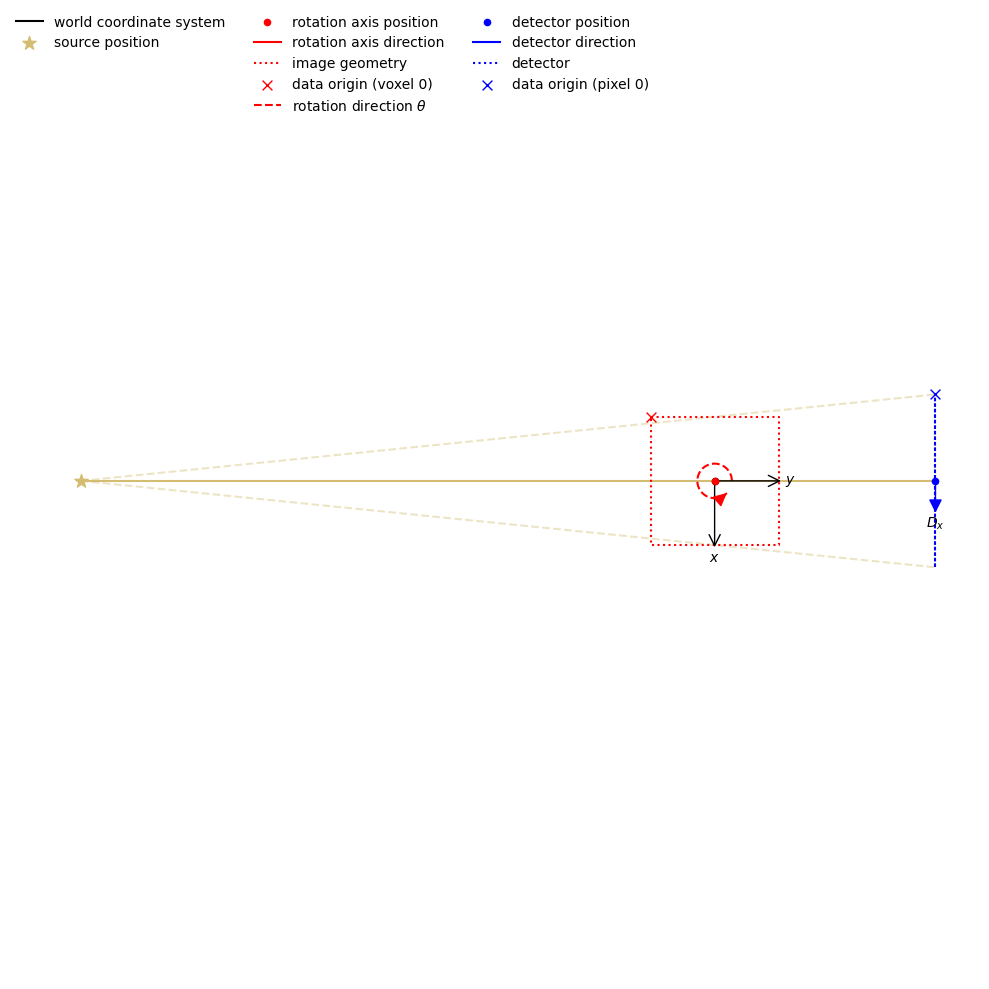

In [34]:
show_geometry(data.geometry)

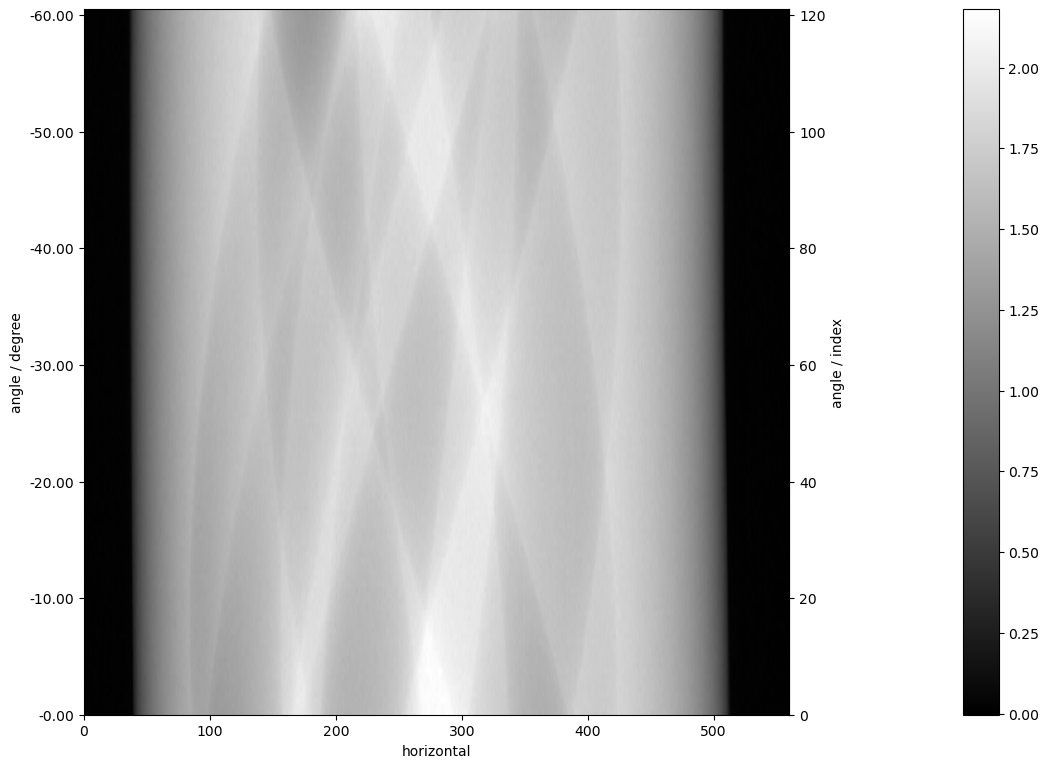

In [35]:
show2D(data)

FDK recon

Input Data:
	angle: 121
	horizontal: 560

Reconstruction Volume:
	horizontal_y: 560
	horizontal_x: 560

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False



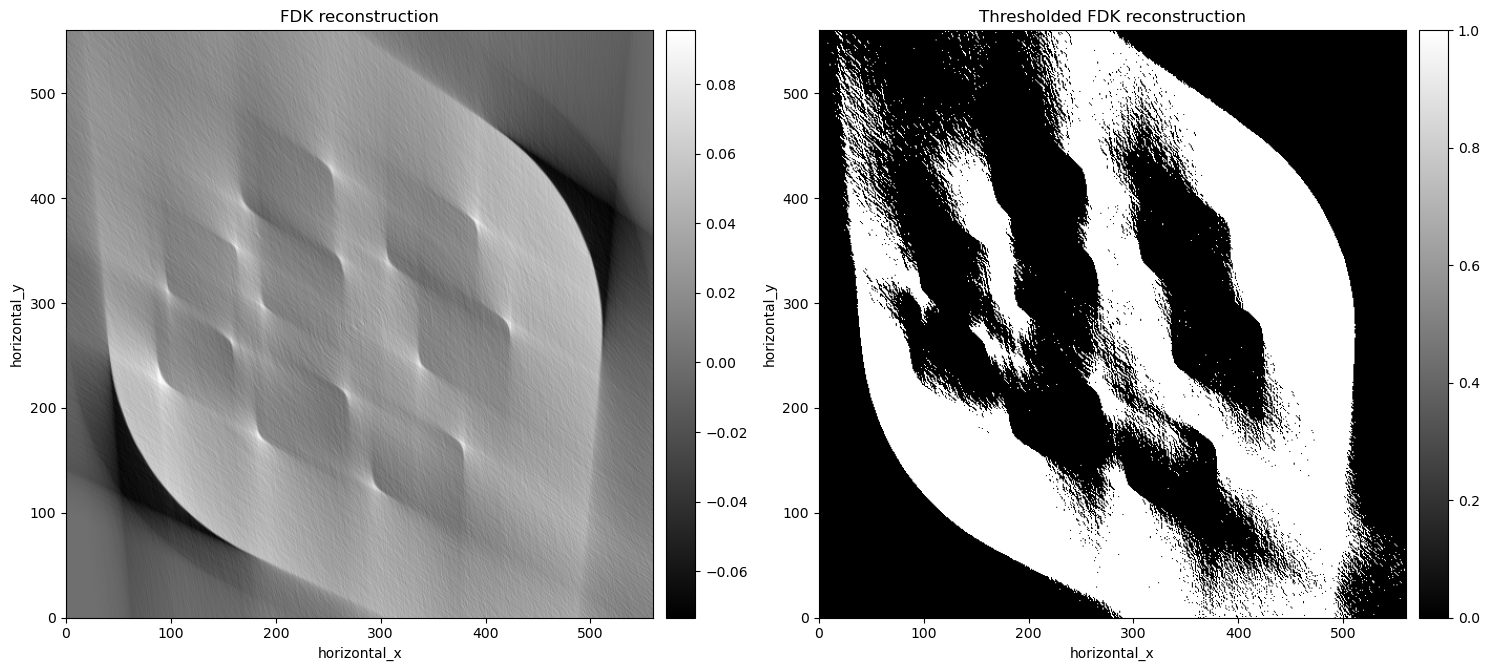

In [36]:
ig=data.geometry.get_ImageGeometry()
fdk =  FDK(data, ig)
recon = fdk.run()
show2D([recon, apply_crazy_threshold(recon)], title=['FDK reconstruction', 'Thresholded FDK reconstruction']);

We see that the missing angles leads to poor reconstructions along the edges parallel to the bottom left to top right.

## Known information 

We now add additional information to the reconstruction through preproccessing and variational regularisation. We utilise the following facts:
- The objects are made of a single homogeneous material​
- The objects have sharp edges 
- The objects are approximately disc shaped
- There is zero attenuation value outside the object 
- There is a constant attenuation value of 0.0409 mm-1 inside the object


Throughout the next sections we will highlight in bold where we have used these assumptions. 

## Preprocess the data

We first normalise the data and pad with zeros. For more information see the "helper_functions.py" file. 

FDK recon

Input Data:
	angle: 121
	horizontal: 732

Reconstruction Volume:
	horizontal_y: 560
	horizontal_x: 560

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False



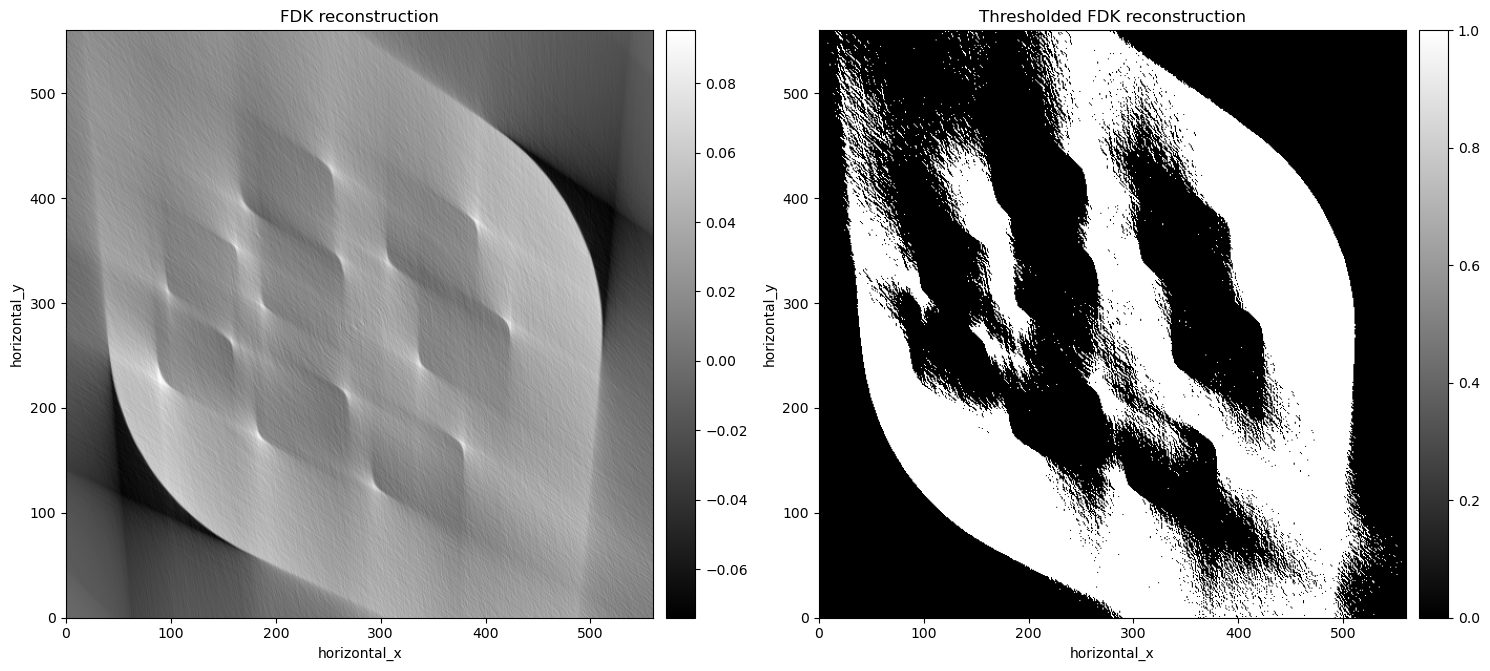

In [37]:
# renormalise data
data_renorm = correct_normalisation(data)
# pad data
data_pad = pad_zeros(data_renorm)


#plot the reconstructed image
fdk =  FDK(data_pad, ig)
recon = fdk.run()
show2D([recon, apply_crazy_threshold(recon)], title=['FDK reconstruction', 'Thresholded FDK reconstruction']);

When plotting a line plot, along the centre of the reconstructed images we see evidence of beam hardening. Beam hardening is when the energy distribution of X-rays shifts toward the higher side as X-rays go through an object. It is visible in the line plot as a "u" shaped "cup" where the material should have a constant absorption value, such as on the right hand side in this plot. 

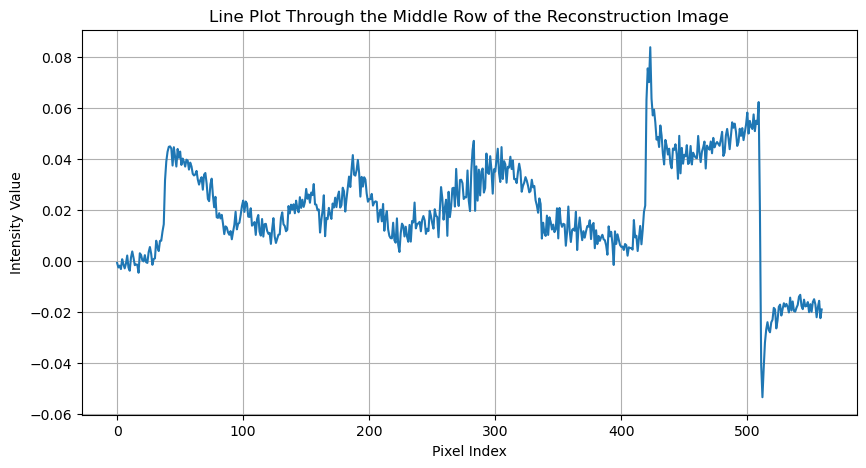

In [38]:
# Extract the middle row of the reconstruction image
middle_row = recon.array[recon.shape[0] // 2, :]

# Plot the values
plt.figure(figsize=(10, 5))
plt.plot(middle_row)
plt.title('Line Plot Through the Middle Row of the Reconstruction Image')
plt.xlabel('Pixel Index')
plt.ylabel('Intensity Value')
plt.grid(True)
plt.show()

Correcting the beam hardening artefacts is relatively straightforward for this example as the object being imaged is made of **one constant material**. We can use the `correct_beam_hardening` function from the `helper_functions` module to correct the beam hardening artefacts. This gives a small improvement to the reconstructed image and line profile:

FDK recon

Input Data:
	angle: 121
	horizontal: 732

Reconstruction Volume:
	horizontal_y: 560
	horizontal_x: 560

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False



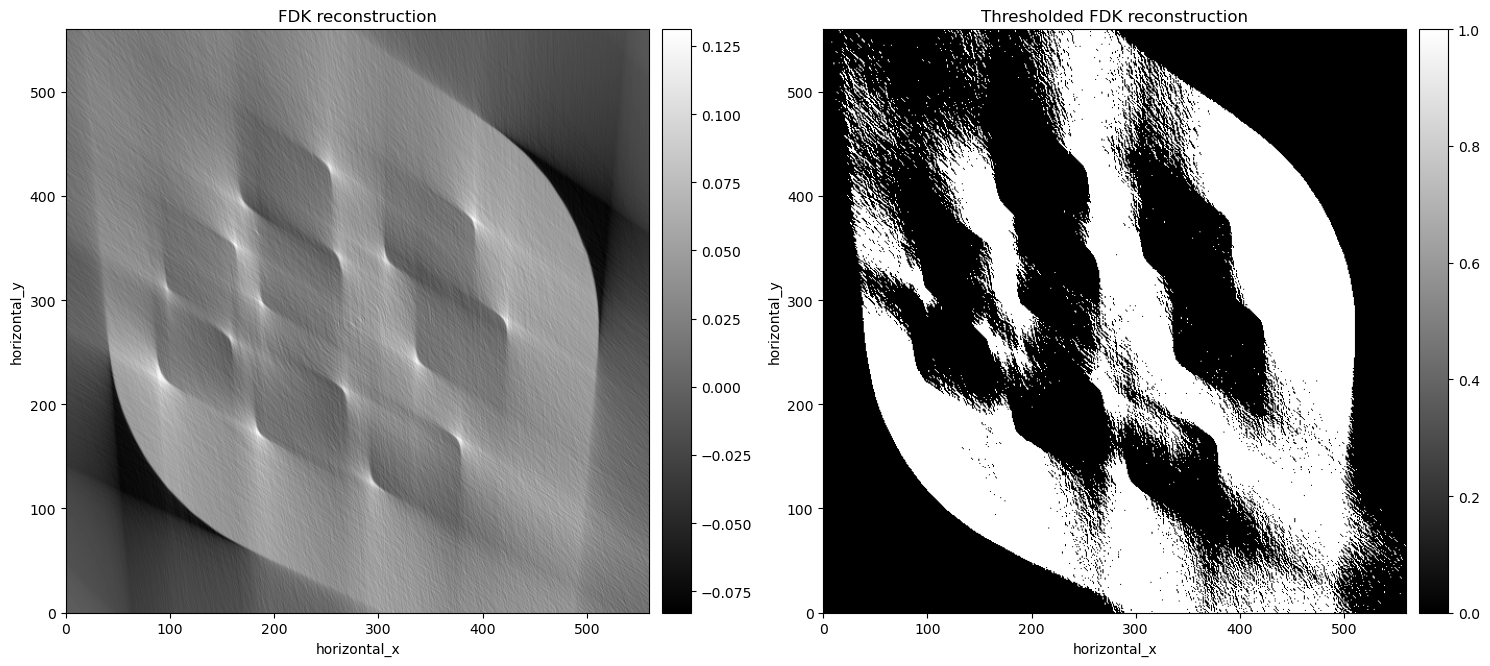

In [39]:
# apply beam hardening correction
data_preprocessed = apply_BHC(data_pad)
#plot the reconstructed image
fdk =  FDK(data_preprocessed, ig)
recon_preprocessed = fdk.run()
show2D([recon_preprocessed, apply_crazy_threshold(recon_preprocessed)], title=['FDK reconstruction', 'Thresholded FDK reconstruction']);

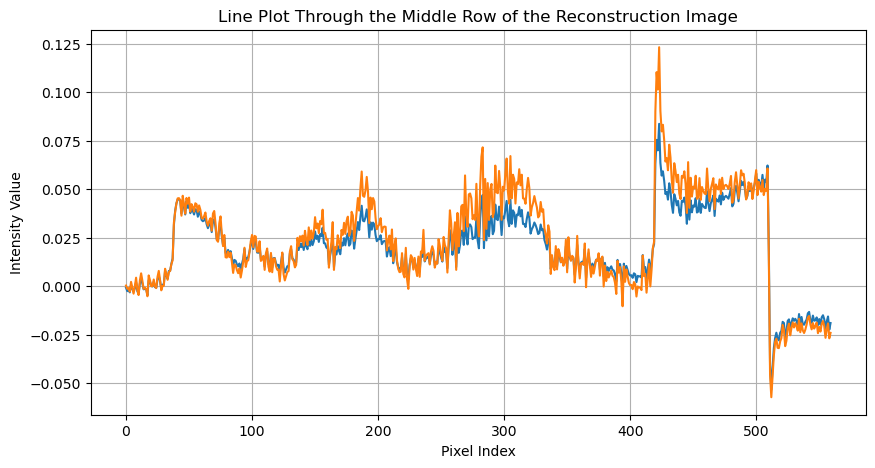

In [40]:
# Extract the middle row of the reconstruction image
middle_row = recon.array[recon.shape[0] // 2, :]
middle_row_preprocessed = recon_preprocessed.array[recon.shape[0] // 2, :]

# Plot the values
plt.figure(figsize=(10, 5))
plt.plot(middle_row)
plt.plot(middle_row_preprocessed)
plt.title('Line Plot Through the Middle Row of the Reconstruction Image')
plt.xlabel('Pixel Index')
plt.ylabel('Intensity Value')
plt.grid(True)
plt.show()

## Isotropic TV reconstruction

**The objects have sharp edges** and are made of **one constant material** and this suggests using TV regularisation, which favours cartoon like images with sharp edges.  

We wish to solve

$$  \arg\min_x \|Ax-y\|_2^2 + \alpha \mathrm{TV}(x) $$

where total variation (isotropic) is defined as $$\mathrm{TV}(u) = \|\nabla u \|_{2,1} = \sum \sqrt{ (\partial_{y}u)^{2} + (\partial_{x}u)^{2} }$$. 

We implement this regularisation using the CIL optimisation toolkit and make use of the (explicit) PDHG algorithm as an optimisation algorithm because of its flexibility. Call this method **($L^{2}-TV$) Explicit PDHG** .

In order to use the PDHG algorithm for the problem above, we need to express our minimisation problem into the following form:

<a id='PDHG_form'></a>
$$
\min_{u\in\mathbb{X}} \mathcal{F}(K u) + \mathcal{G}(u)
\tag{PDHG form}
$$

where we assume that:

1. $\mathcal{F}$, $\mathcal{G}$ are __convex__ functionals:
    
    - $\mathcal{F}: \mathbb{Y} \rightarrow \mathbb{R}$ 
    
    - $\mathcal{G}: \mathbb{X} \rightarrow \mathbb{R}$
    
    
1. $K$ is a continuous linear operator acting from a space $\mathbb{X}$ to another space $\mathbb{Y}$ :

    $$K : \mathbb{X} \rightarrow \mathbb{Y} \quad $$ 

    with operator norm  defined as $$\| K \| = \max\{ \|K x\|_{\mathbb{Y}} : \|x\|_{\mathbb{X}}\leq 1 \}.$$  






For the setup of the **($L^{2}-TV$) Explicit PDHG**, we let

$$\begin{align}
& f_{1}: \mathbb{Y} \rightarrow \mathbb{R}, \quad f_{1}(z_{1}) = \alpha\,\|z_{1}\|_{2,1}, \text{ ( the TV term ) }\\
& f_{2}: \mathbb{X} \rightarrow \mathbb{R}, \quad f_{2}(z_{2}) = \frac{1}{2}\|z_{2} - g\|_{2}^{2}, \text{ ( the data-fitting term ). }
\tag{1}
\end{align}$$

```python

                                f1 = alpha * MixedL21Norm()
                                f2 = 0.5 * L2NormSquared(b=absorption_data)

```



For $z = (z_{1}, z_{2})\in \mathbb{Y}\times \mathbb{X}$, we define a separable function, e.g., BlockFunction, see the [appendix](../appendix.ipynb).

$$\mathcal{F}(z) : = \mathcal{F}(z_{1},z_{2}) = f_{1}(z_{1}) + f_{2}(z_{2})$$



```python
    
                                         F = BlockFunction(f1, f2)
       
```


In order to obtain an element $z = (z_{1}, z_{2})\in \mathbb{Y}\times \mathbb{X}$, we need to define a `BlockOperator` $K$, using the two operators involved in [$L^{2}-TV$](#TomoTV), i.e., the `GradientOperator` $\nabla$ and the `ProjectionOperator` $\mathcal{A}$.

$$ \mathcal{K} = 
\begin{bmatrix}
\nabla\\
\mathcal{A}
\end{bmatrix}
$$



```python
    
                                        Grad = GradientOperator(ig)
                                        K = BlockOperator(Grad, A)
       
```

Finally, we set  $\mathcal{G} \equiv 0 $ and so  `G = ZeroFunction(lower=0)`.

We can verify that with the above setting we can express our problem into PDHG form, 

$$
\begin{align}
\arg\min_x   \alpha\|\nabla x\|_{2,1} + \frac{1}{2}\|\mathcal{A} x - g\|^{2}_{2} + 0 =  \arg\min_x   f_{1}(\nabla x) + f_{2}(\mathcal{A}x) + 0 \\ = \arg\min_x   F\left(
\begin{bmatrix}
\nabla \\
\mathcal{A}
\end{bmatrix}x\right) + 0 = 
\arg\min_x \mathcal{F}(Kx) + \mathcal{G}(x) 
\end{align}
\tag{2}
$$

    





In [41]:
ang_range = np.abs(data_preprocessed.geometry.angles[-1]-data_preprocessed.geometry.angles[0])
omega = 90.0/ang_range

alpha = 0.01/omega
Grad = GradientOperator(ig)
A = ProjectionOperator(ig, data.geometry)
Id = IdentityOperator(ig)
K = BlockOperator(A, Grad)

f1 = L2NormSquared(b=data)
f2 = alpha*MixedL21Norm()
F = BlockFunction(f1, f2)

G = ZeroFunction()

normK = K.norm()
sigma = 1.0
tau = 1.0/(sigma*normK**2)

algo = PDHG(initial=ig.allocate(0.0),
            f=F, g=G, operator=K, 
            sigma=sigma, tau=tau,
            update_objective_interval=100)
algo.run(2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

We can visualise the results: 


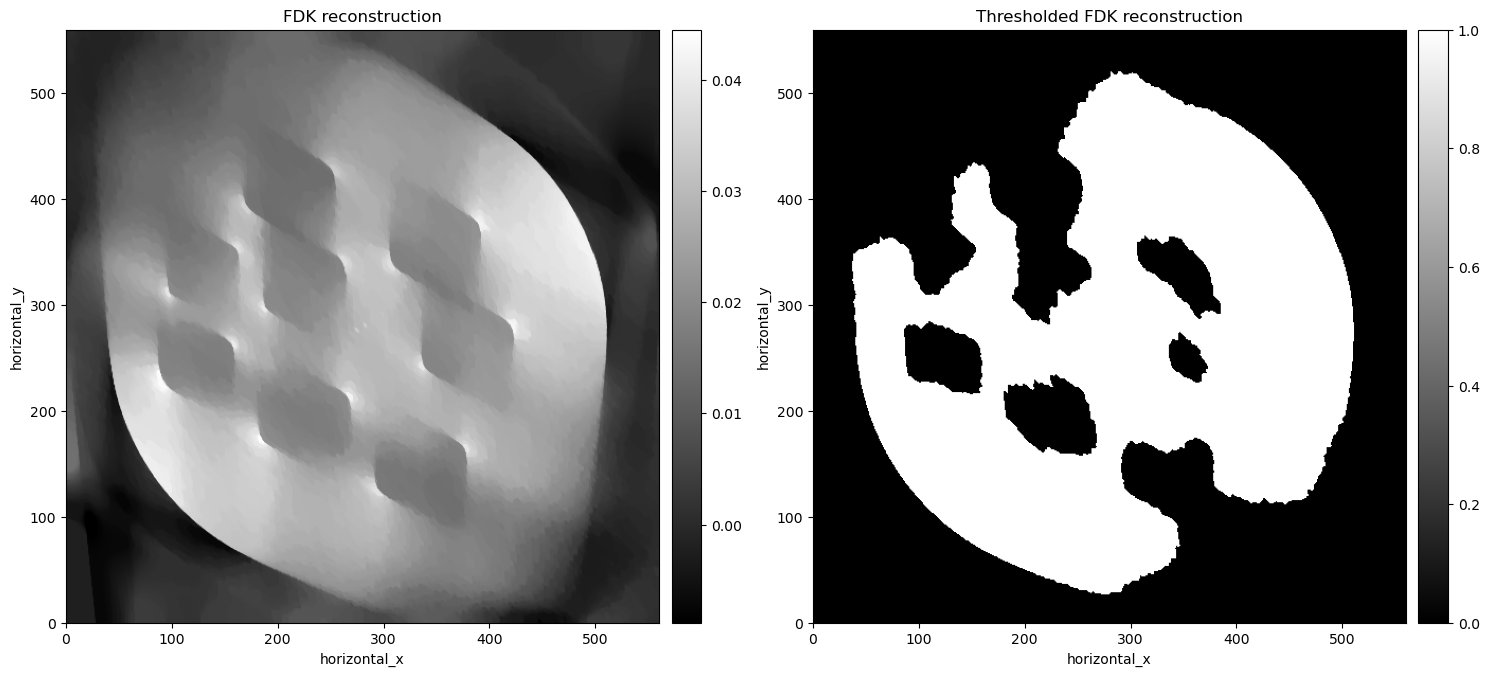

In [42]:
show2D([algo.solution, apply_crazy_threshold(algo.solution)], title=['FDK reconstruction', 'Thresholded FDK reconstruction']);

We see from the reconstruction that there are negative values and the background is not uniformly 0. We know that tomographic reconstructions should take positive values and we know that for this dataset that there should be **no attenuation in the background**, and that **there is a constant attenuation value of 0.0409 mm-1 inside the object**. We use an indicator function to enforce this in our solution. 

Finally, we enforce a non-negativity constraint by letting $\mathcal{G} = \mathbb{I}_{\{u>0\}}(u)$ $\Longleftrightarrow$ `G = IndicatorBox(lower=0)`
    


  0%|          | 0/2000 [00:00<?, ?it/s]

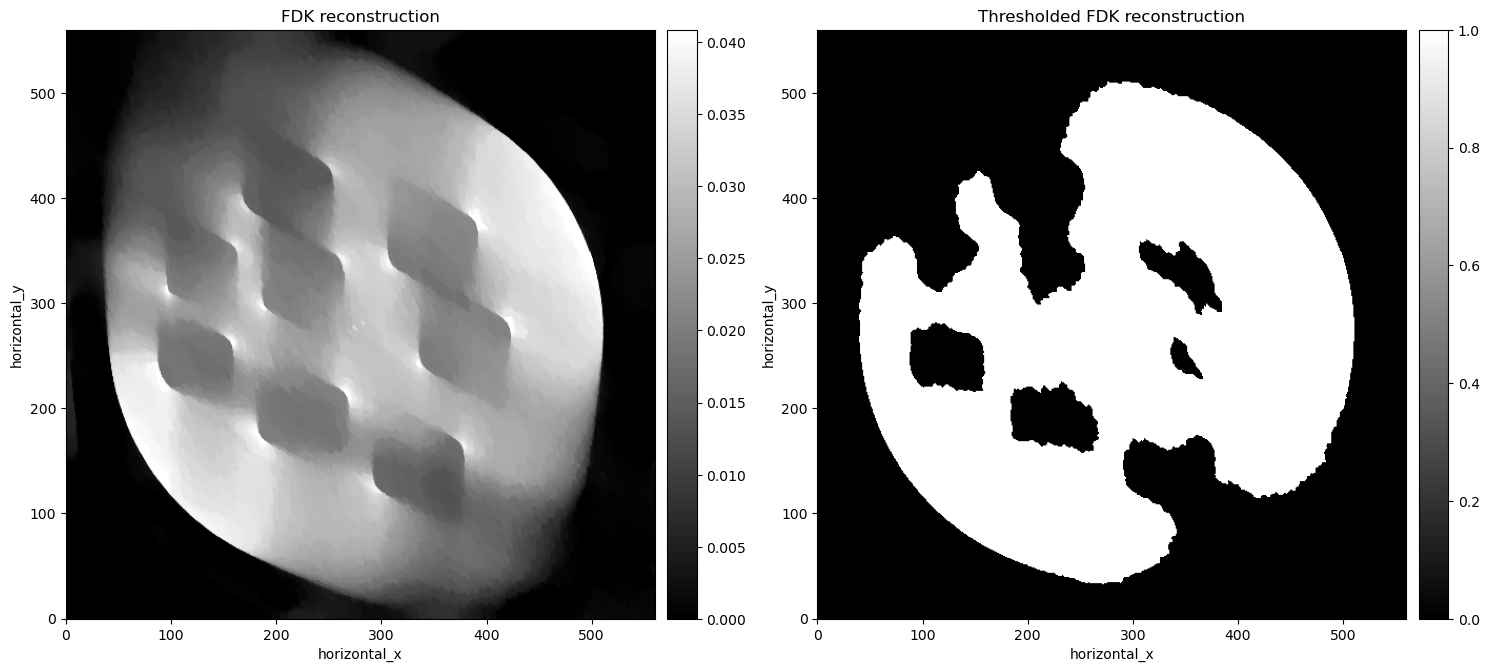

In [43]:
alpha = 0.01/omega
ub_val = 0.040859 # acrylic_attenuation in unit 1/mm


Grad = GradientOperator(ig)
A = ProjectionOperator(ig, data.geometry)
Id = IdentityOperator(ig)
K = BlockOperator(A, Grad)

f1 = L2NormSquared(b=data)
f2 = alpha*MixedL21Norm()
F = BlockFunction(f1, f2)

G = IndicatorBox(lower=0, upper=ub_val)

normK = K.norm()
sigma = 1.0
tau = 1.0/(sigma*normK**2)

algo = PDHG(initial=ig.allocate(0.0),
            f=F, g=G, operator=K, 
            sigma=sigma, tau=tau,
            update_objective_interval=100)
algo.run(2000)
show2D([algo.solution, apply_crazy_threshold(algo.solution)], title=['FDK reconstruction', 'Thresholded FDK reconstruction']);

The background of the reconstruction looks better and there are no negative values but the segmentation looks worse! 

We now use the fact that the **object is approximately disc shaped**. We use the clear disc edges on the bottom left and top right in the FDK to fit the disc (see the file "/htc_code/helper_functions.py" for more detail. 

FDK recon

Input Data:
	angle: 121
	horizontal: 560

Reconstruction Volume:
	horizontal_y: 560
	horizontal_x: 560

Reconstruction Options:
	Backend: tigre
	Filter: ram-lak
	Filter cut-off frequency: 1.0
	FFT order: 11
	Filter_inplace: False



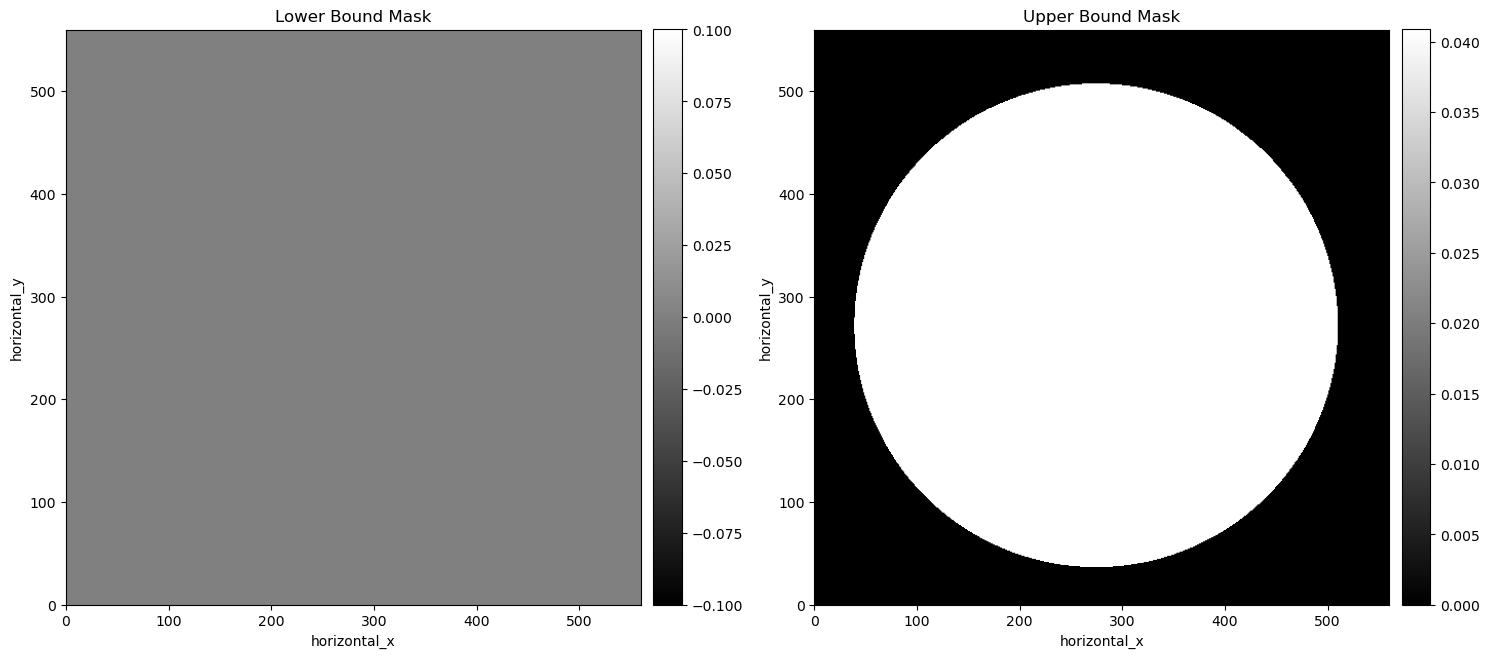

In [44]:
# Upper bound mask
ub_val = 0.040859 # acrylic_attenuation in unit 1/mm
ub_mask_type = 2   # 1 basic 0.97 circle. 2 fitted
basic_mask_radius = 0.97

# Lower bound mask
lb_mask_type = 0   # 0:  lower bound 0 everywhere, 1: outer annulus equal to upper bound acrylic
lb_inner_radius = 200
lb_val = ub_val  # could be changed to 0.04 or other smaller values

lb, ub = create_lb_ub(data, ig, ub_mask_type, lb_mask_type, 
                        ub_val, lb_val, basic_mask_radius, lb_inner_radius);

show2D([lb, ub], title=['Lower Bound Mask', 'Upper Bound Mask']);

We can now pass the lower and upper bound masks to the PDHG algorithm:

  0%|          | 0/2000 [00:00<?, ?it/s]

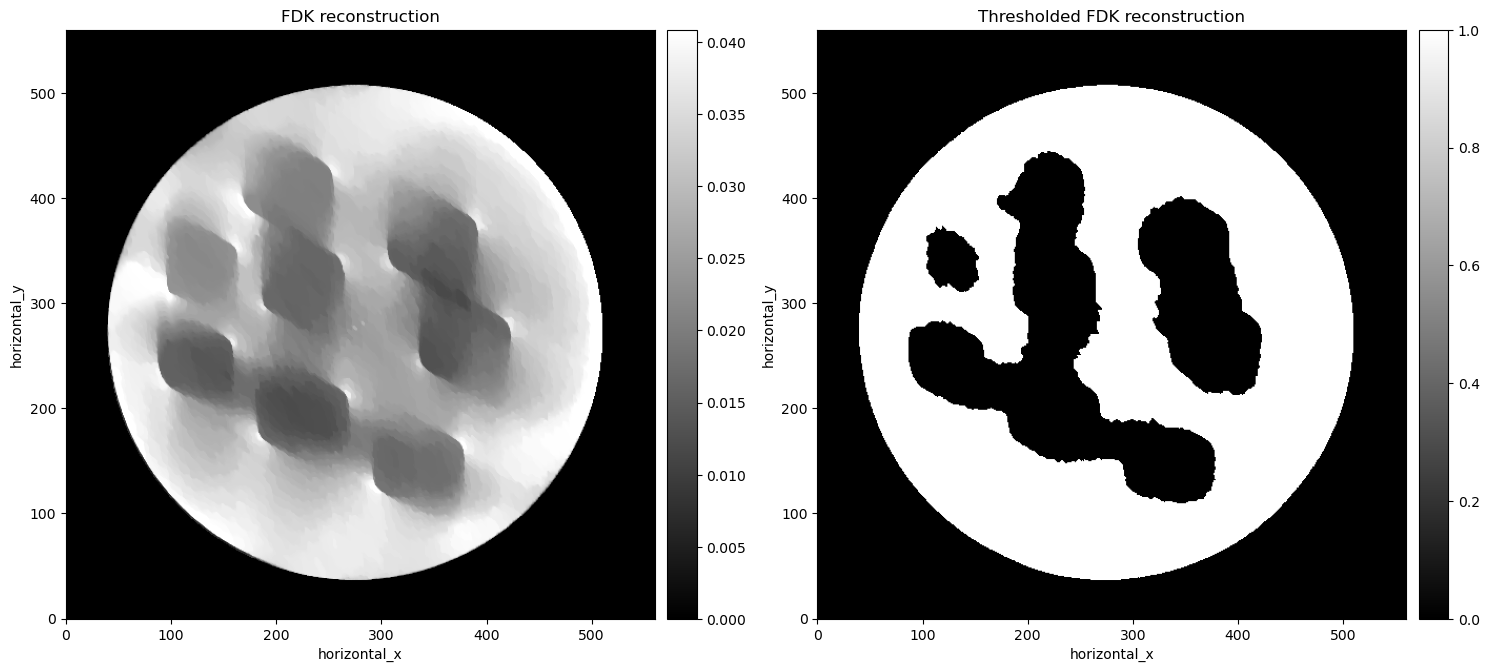

In [45]:
alpha = 0.01/omega

Grad = GradientOperator(ig)
A = ProjectionOperator(ig, data.geometry)
Id = IdentityOperator(ig)
K = BlockOperator(A, Grad)

f1 = L2NormSquared(b=data)
f2 = alpha*MixedL21Norm()
F = BlockFunction(f1, f2)

G = IndicatorBox(lower=lb, upper=ub)

normK = K.norm()
sigma = 1.0
tau = 1.0/(sigma*normK**2)

algo = PDHG(initial=ig.allocate(0.0),
            f=F, g=G, operator=K, 
            sigma=sigma, tau=tau,
            update_objective_interval=100)
algo.run(2000)
show2D([algo.solution, apply_crazy_threshold(algo.solution)], title=['FDK reconstruction', 'Thresholded FDK reconstruction']);

## Isotropic and Anisotropic TV 



In [ ]:
#TODO: Some more explanation of this approach 



In [46]:


# Reconstruction
alpha = 0.01/omega
alpha_dx = 0.03/omega

ag_rotated = data.geometry.copy()
    
ang_middle = (data.geometry.angles[0]+data.geometry.angles[-1])/2
ag_rotated.set_angles(data.geometry.angles - ang_middle, angle_unit='degree')

data = AcquisitionData(data.as_array(), geometry=ag_rotated)


Grad = GradientOperator(ig)
A = ProjectionOperator(ig, data.geometry)
Dx = FiniteDifferenceOperator(ig, direction='horizontal_x')
K12x = BlockOperator(A, Grad, Dx)

f1 = L2NormSquared(b=data)
f2 = alpha*MixedL21Norm()
f_dx = alpha_dx*L1Norm()
F12x = BlockFunction(f1, f2, f_dx)

lb_copy = lb.copy()
ub_copy = ub.copy()
lb_copy.array = rotate(lb.as_array(), -ang_middle)
ub_copy.array = rotate(ub.as_array(), -ang_middle)

G = IndicatorBox(lower=lb_copy, upper=ub_copy)

normK = K12x.norm()
sigma = 1.0
tau = 1.0/(sigma*normK**2)

algo = PDHG(initial=ig.allocate(0.0),
        f=F12x, g=G, operator=K12x, 
        sigma=sigma, tau=tau,
        update_objective_interval=update_objective_interval)
algo.run(2000)
sol =  algo.solution.copy()
sol.array = rotate(sol.as_array(), ang_middle)




  0%|          | 0/2000 [00:00<?, ?it/s]

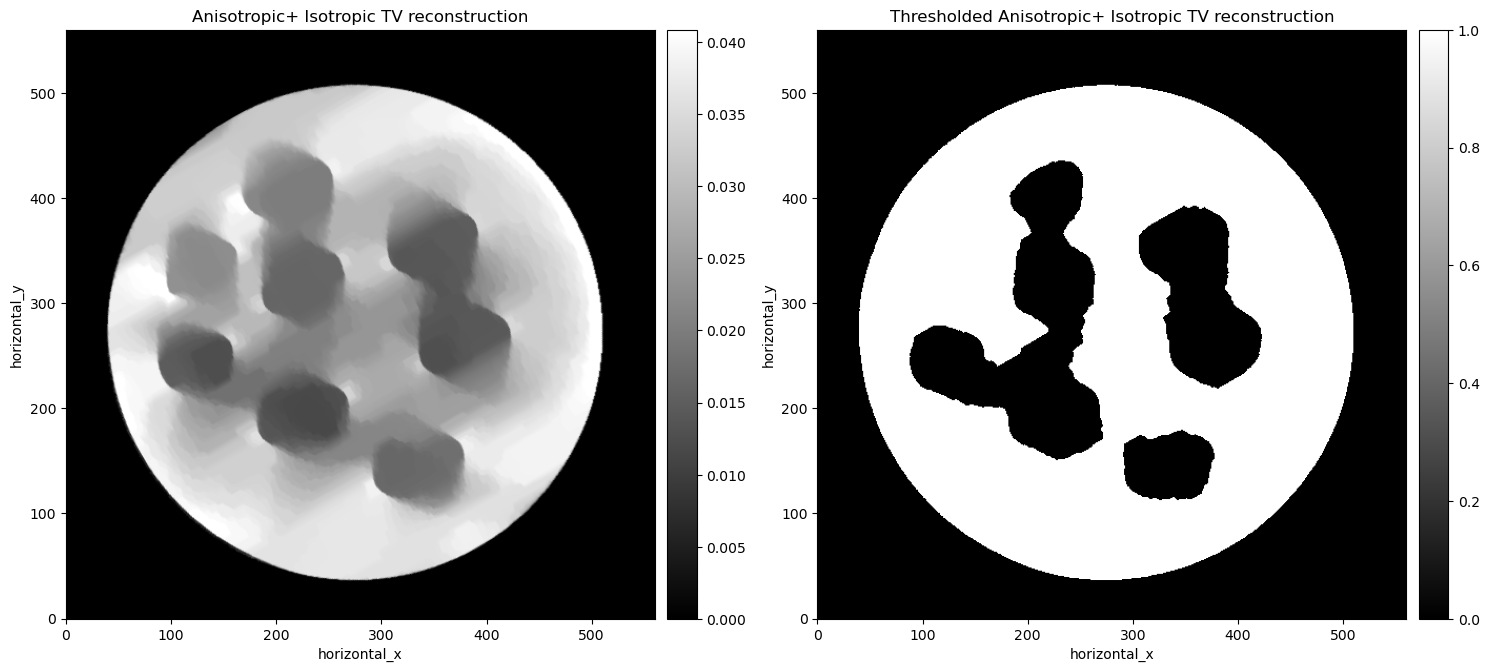

In [47]:
show2D([sol, apply_crazy_threshold(sol)], title=['Anisotropic+ Isotropic TV reconstruction', 'Thresholded Anisotropic+ Isotropic TV reconstruction']);